In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sys 
import os 

sys.path.append('../../../')
from src.athena import Athena
from src.utils import create_session

## Global

In [2]:
boto3_session = create_session(profile_name='dev', role_arn='arn:aws:iam::722696965592:role/athena-full-access-role')

wait = True
ctas_approach = False

database = "dannys_diner"
tables = ['menu', 'sales', 'members']

athena = Athena(boto3_session=boto3_session, s3_output=os.getenv('ATHENA_S3_OUTPUT'))
athena

Athena(boto3_session=Session(region_name='us-east-1'), s3_output=s3://sql-case-studies/query_results)

## Context 

Danny is a passionate lover of Japanese cuisine. At the beginning of 2021, he decided to embark on a bold venture by opening a charming restaurant named Danny’s Diner, specializing in his three favorite dishes: sushi, curry, and ramen.

Danny’s Diner is currently in need of assistance to ensure its sustainability. While the restaurant has collected some basic data over the past few months, the team lacks the expertise to leverage this data to improve business operations.

## Problem Statement

Danny seeks to utilize the available data to answer key questions about his customers, focusing on their visiting patterns, spending habits, and favorite menu items. Gaining these insights will enable him to foster a deeper connection with his customers and provide a more personalized dining experience for his loyal patrons.

Additionally, Danny intends to use these insights to determine whether to expand the existing customer loyalty program. He also requires assistance in generating basic datasets to allow his team to inspect the data easily without needing to use SQL.

## Entity Relationship Diagram

<center>
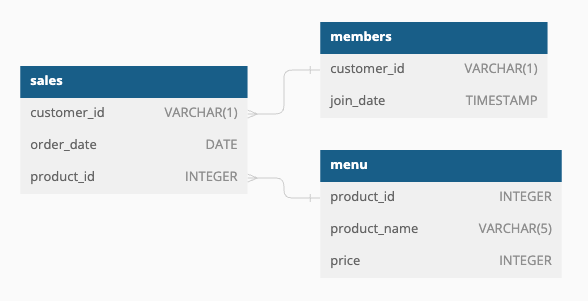
</center>

## Tables

In [5]:
for table in tables:
    athena.query(
        database=database,
        query=f""" 
                SELECT
                    *
                FROM
                    {database}.{table} TABLESAMPLE BERNOULLI(50);
              """,
        ctas_approach=ctas_approach
    )

,customer_id,order_date,product_id
0,A,2021-01-01,1
1,A,2021-01-01,2
2,A,2021-01-07,2
3,A,2021-01-10,3
4,A,2021-01-11,3
5,A,2021-01-11,3
6,B,2021-01-11,1
7,B,2021-01-16,3
8,C,2021-01-01,3
9,C,2021-01-01,3


,product_id,product_name,price
0,2,curry,15.0
1,3,ramen,12.0


,customer_id,join_date
0,A,2021-01-07


## Q1

What is the total amount each customer spent at the restaurant?

In [6]:
q1_query = """
SELECT
  s.customer_id AS customer_id,
  SUM(m.price) AS total_spent
FROM
  dannys_diner.sales AS s
  LEFT JOIN dannys_diner.menu AS m ON s.product_id = m.product_id
GROUP BY
  s.customer_id
ORDER BY 
  total_spent DESC;
"""

athena.query(
    database=database,
    query=q1_query,
    ctas_approach=ctas_approach
)

,customer_id,total_spent
0,A,76.0
1,B,74.0
2,C,36.0


## Q2

How many days has each customer visited the restaurant?

In [7]:
q2_query = """
SELECT
  customer_id,
  COUNT(DISTINCT order_date) AS num_visits
FROM
  dannys_diner.sales
GROUP BY
  customer_id
ORDER BY
  num_visits DESC;
"""

athena.query(
    database=database,
    query=q2_query,
    ctas_approach=ctas_approach
)

,customer_id,num_visits
0,B,6
1,A,4
2,C,2


## Q3

What was the first item(s) from the menu purchased by each customer?

In [8]:
q3_cte_query = """
  SELECT
    s.customer_id AS customer_id,
    RANK() OVER (
      PARTITION BY s.customer_id
      ORDER BY s.order_date
    ) AS rank_number,
    s.order_date AS order_date,
    m.product_name AS product_name
  FROM
    dannys_diner.sales AS s
    LEFT JOIN dannys_diner.menu AS m ON s.product_id = m.product_id;
"""

athena.query(
    database=database,
    query=q3_cte_query,
    ctas_approach=ctas_approach
)

,customer_id,rank_number,order_date,product_name
0,C,1,2021-01-01,ramen
1,C,1,2021-01-01,ramen
2,C,3,2021-01-07,ramen
3,A,1,2021-01-01,sushi
4,A,1,2021-01-01,curry
5,A,3,2021-01-07,curry
6,A,4,2021-01-10,ramen
7,A,5,2021-01-11,ramen
8,A,5,2021-01-11,ramen
9,B,1,2021-01-01,curry


In [9]:
q3_query = """
WITH sales_data AS (
  SELECT
    s.customer_id AS customer_id,
    RANK() OVER (
      PARTITION BY s.customer_id
      ORDER BY s.order_date
    ) AS rank_number,
    s.order_date AS order_date,
    m.product_name AS product_name
  FROM
    dannys_diner.sales AS s
    LEFT JOIN dannys_diner.menu AS m ON s.product_id = m.product_id
)
SELECT
  customer_id,
  order_date,
  product_name
FROM
  sales_data
WHERE
  rank_number = 1
ORDER BY
  customer_id;
"""

athena.query(
    database=database,
    query=q3_query,
    ctas_approach=ctas_approach
)

,customer_id,order_date,product_name
0,A,2021-01-01,sushi
1,A,2021-01-01,curry
2,B,2021-01-01,curry
3,C,2021-01-01,ramen
4,C,2021-01-01,ramen


### RANK() Function

The `RANK()` function is a window function that assigns a rank, $1, ..., n$, to each row within a partition of a result set. 

The rows within a partition that have the same values will receive the same rank. The next row will receive a rank that is incremented by the number of rows that have the same values, and so the rank may not be consecutive.

```sql
RANK() OVER (
    [PARTITION BY partition_expression, ... ]
    ORDER BY sort_expression [ASC | DESC], ...
)
```

- `PARTITION BY`: The `PARTITION BY` clause divides the result set into partitions to which the `RANK()` function is applied. If the `PARTITION BY` clause is not specified, the `RANK()` function treats the whole result set as a single partition.

- `ORDER BY`: The `ORDER BY` clause specifies the column or columns that the `RANK()` function uses to determine the order of rows within a partition. If the `ORDER BY` clause is not specified, the `RANK()` function assigns a unique rank to each row within a partition.

## Q4

What is the most purchased item on the menu and how many times was it purchased by all customers?

In [10]:
q4_query = """
SELECT
  m.product_name AS product_name,
  COUNT(m.product_name) AS times_purchased
FROM
  dannys_diner.sales AS s
  LEFT JOIN dannys_diner.menu AS m ON s.product_id = m.product_id
GROUP BY
  m.product_name
ORDER BY
  times_purchased DESC
LIMIT 1;
"""

athena.query(
    database=database,
    query=q4_query,
    ctas_approach=ctas_approach
)

,product_name,times_purchased
0,ramen,8


## Q5

Which item was the most popular for each customer?

### Using Multiple Level Partitioning

The first approach uses multiple level partitioning to calculate the number of times each customer purchased each product and the total number of times each product was purchased.

* The first `COUNT()` function calculates the number of times each customer purchased each product.

* The second `COUNT()` function calculates the total number of times each product was purchased by all customers.

In [11]:
q5_mlp_query = """
SELECT
    s.customer_id AS customer_id,

    COUNT(s.product_id) OVER (
        PARTITION BY s.customer_id, s.product_id
        ORDER BY m.product_name
    ) AS times_purchased_by_customer_and_product,

    COUNT(s.product_id) OVER (
        PARTITION BY s.product_id
    ) AS times_purchased_total_by_product,

    m.product_name AS product_name
FROM
    dannys_diner.sales AS s
    LEFT JOIN dannys_diner.menu AS m ON s.product_id = m.product_id
ORDER BY
  customer_id, times_purchased_by_customer_and_product DESC;
"""

athena.query(
    database=database,
    query=q5_mlp_query,
    ctas_approach=ctas_approach
)

,customer_id,times_purchased_by_customer_and_product,times_purchased_total_by_product,product_name
0,A,3,8,ramen
1,A,3,8,ramen
2,A,3,8,ramen
3,A,2,4,curry
4,A,2,4,curry
5,A,1,3,sushi
6,B,2,4,curry
7,B,2,3,sushi
8,B,2,4,curry
9,B,2,3,sushi


### CTE & RANK() Function

The second approach uses a Common Table Expression (CTE) to rank the number of times each product was purchased by each customer and filter the most popular product for each customer. This ensures that ties are handled correctly, i.e., if two products are equally popular, both products will be included in the result.

In [12]:
q5_cte_query = """
SELECT
    s.customer_id AS customer_id,
    m.product_name AS product_name,
    COUNT(m.product_name) AS times_purchased,
    RANK() OVER (
        PARTITION BY s.customer_id
        ORDER BY COUNT(m.product_name) DESC
    ) AS rank_number
FROM
    dannys_diner.sales AS s
    LEFT JOIN dannys_diner.menu AS m ON s.product_id = m.product_id
GROUP BY
    s.customer_id, m.product_name;
"""

athena.query(
    database=database,
    query=q5_cte_query,
    ctas_approach=ctas_approach
)

,customer_id,product_name,times_purchased,rank_number
0,C,ramen,3,1
1,A,ramen,3,1
2,A,curry,2,2
3,A,sushi,1,3
4,B,curry,2,1
5,B,sushi,2,1
6,B,ramen,2,1


In [13]:
q5_query = """
WITH ranked_sales AS (
    SELECT
        s.customer_id AS customer_id,
        m.product_name AS product_name,
        COUNT(m.product_name) AS times_purchased,
        RANK() OVER (
            PARTITION BY s.customer_id
            ORDER BY COUNT(m.product_name) DESC
        ) AS rank_number
    FROM
        dannys_diner.sales AS s
        LEFT JOIN dannys_diner.menu AS m ON s.product_id = m.product_id
    GROUP BY
        s.customer_id, m.product_name
)
SELECT
    customer_id,
    product_name,
    times_purchased
FROM
    ranked_sales
WHERE
    rank_number = 1
ORDER BY
    customer_id;
"""

athena.query(
    database=database,
    query=q5_query,
    ctas_approach=ctas_approach
)

,customer_id,product_name,times_purchased
0,A,ramen,3
1,B,sushi,2
2,B,ramen,2
3,B,curry,2
4,C,ramen,3


## Q6

Which item was purchased first by the customer after they became a member and what date (including the date they joined) was it? 

In [14]:
q6_cte_query = """
  SELECT
    s.customer_id AS customer_id,
    s.order_date AS order_date,
    menu.product_name AS product_name,
    RANK() OVER (
      PARTITION BY s.customer_id
      ORDER BY order_date ASC
    ) AS rank_number
  FROM
    dannys_diner.sales AS s
    LEFT JOIN dannys_diner.members AS memb ON s.customer_id = memb.customer_id
    LEFT JOIN dannys_diner.menu AS menu ON s.product_id = menu.product_id
  WHERE
    order_date >= join_date;
"""

athena.query(
    database=database,
    query=q6_cte_query,
    ctas_approach=ctas_approach
)

,customer_id,order_date,product_name,rank_number
0,A,2021-01-07,curry,1
1,A,2021-01-10,ramen,2
2,A,2021-01-11,ramen,3
3,A,2021-01-11,ramen,3
4,B,2021-01-11,sushi,1
5,B,2021-01-16,ramen,2
6,B,2021-02-01,ramen,3


In [15]:
q6_query = """
WITH ranked_sales AS (
  SELECT
    s.customer_id AS customer_id,
    s.order_date AS order_date,
    menu.product_name AS product_name,
    RANK() OVER (
      PARTITION BY s.customer_id
      ORDER BY order_date ASC
    ) AS rank_number
  FROM
    dannys_diner.sales AS s
    LEFT JOIN dannys_diner.members AS memb ON s.customer_id = memb.customer_id
    LEFT JOIN dannys_diner.menu AS menu ON s.product_id = menu.product_id
  WHERE
    order_date >= join_date
)
SELECT
  customer_id,
  order_date,
  product_name
FROM
  ranked_sales
WHERE
  rank_number = 1;
"""

athena.query(
    database=database,
    query=q6_query,
    ctas_approach=ctas_approach
)

,customer_id,order_date,product_name
0,A,2021-01-07,curry
1,B,2021-01-11,sushi


The `RANK()` function is used to assign a rank to each row within a partition of `customer_id` based on the `order_date` in ascending order. The `rank_number` is used to filter the first item purchased by the customer after they became a member.

## Q7

Which item was purchased just before the customer became a member and what date was it?

This is the reverse of the previous question. The two differences are:

* Instead of filtering `order_date >= join_date`, we filter `order_date < join_date`.

* The `ORDER BY` clause in the `RANK()` function is changed to `ORDER BY order_date DESC` to rank the `order_date` in descending order. This ensures that the item purchased just before the customer became a member is ranked first.

In [16]:
q7_query = """
WITH ranked_sales AS (
  SELECT
    s.customer_id AS customer_id,
    s.order_date AS order_date,
    menu.product_name AS product_name,
    RANK() OVER (
      PARTITION BY s.customer_id
      ORDER BY order_date DESC
    ) AS rank_number
  FROM
    dannys_diner.sales AS s
    LEFT JOIN dannys_diner.members AS memb ON s.customer_id = memb.customer_id
    LEFT JOIN dannys_diner.menu AS menu ON s.product_id = menu.product_id
  WHERE
    order_date < join_date
)
SELECT
  customer_id,
  order_date,
  product_name
FROM
  ranked_sales
WHERE
  rank_number = 1;
"""

athena.query(
    database=database,
    query=q7_query,
    ctas_approach=ctas_approach
)

,customer_id,order_date,product_name
0,A,2021-01-01,sushi
1,A,2021-01-01,curry
2,B,2021-01-04,sushi


## Q8

What is the total (**distinct**) items and amount spent for each member before they became a member?


In [17]:
q8_query = """
SELECT
  s.customer_id AS customer_id,
  COUNT(DISTINCT menu.product_name) AS item_count,
  SUM(menu.price) AS total_spending
FROM 
  dannys_diner.sales AS s 
  LEFT JOIN dannys_diner.members AS memb ON s.customer_id = memb.customer_id 
  LEFT JOIN dannys_diner.menu AS menu ON s.product_id = menu.product_id
WHERE 
  s.order_date < memb.join_date
GROUP BY
  s.customer_id
ORDER BY
  total_spending DESC;
"""

athena.query(
    database=database,
    query=q8_query,
    ctas_approach=ctas_approach
)

,customer_id,item_count,total_spending
0,B,2,40.0
1,A,2,25.0


## Q9

If each $\$1$ spent equates to $10$ points and sushi has a $2x$ points multiplier - how many points would each customer have?

In [18]:
q9_query = """
SELECT
  s.customer_id,
  SUM(
    CASE
      WHEN menu.product_name = 'sushi' THEN menu.price * 10 * 2
      ELSE menu.price * 10
    END
  ) AS total_points
FROM
  dannys_diner.sales AS s
  LEFT JOIN dannys_diner.members AS memb ON s.customer_id = memb.customer_id
  LEFT JOIN dannys_diner.menu AS menu ON s.product_id = menu.product_id
GROUP BY
  s.customer_id
ORDER BY
  total_points DESC;
"""

athena.query(
    database=database,
    query=q9_query,
    ctas_approach=ctas_approach
)

,customer_id,total_points
0,B,940.0
1,A,860.0
2,C,360.0


## Q10

In the first week after a customer joins the program (including their join date) they earn $2x$ points on all items, not just sushi - how many points do customer A and B have at the end of January?

In [19]:
q10_query = """
SELECT
  s.customer_id AS customer_id,
  SUM(
    CASE
      WHEN s.order_date < memb.join_date
      AND menu.product_name = 'sushi' THEN menu.price * 10 * 2
      WHEN s.order_date >= memb.join_date
      AND DATE_DIFF('day', memb.join_date, s.order_date) <= 6 THEN menu.price * 10 * 2
      ELSE menu.price * 10
    END
  ) AS total_points
FROM
  dannys_diner.sales AS s
  LEFT JOIN dannys_diner.members AS memb ON s.customer_id = memb.customer_id
  LEFT JOIN dannys_diner.menu AS menu ON s.product_id = menu.product_id
WHERE
  s.customer_id IN ('A', 'B')
  AND s.order_date < DATE '2021-02-01'
GROUP BY
  s.customer_id
ORDER BY
  total_points DESC;
"""

athena.query(
    database=database,
    query=q10_query,
    ctas_approach=ctas_approach
)

,customer_id,total_points
0,A,1370.0
1,B,820.0


The `CASE` statement is used to calculate the total points for each customer based on the following conditions:

* If the `order_date` is before the `join_date` and the `product_name` is 'sushi', the customer earns $2x$ points in addition to 10 points per dollar spent.

* If the `order_date` is within the first week after the `join_date`, the customer earns $2x$ points on all items.

* Otherwise, the customer earns 10 points per dollar spent.

In addition, we need to use `DATE_DIFF()` function to calculate the difference between two dates in terms of days. In PostgreSQL, we could simple use the `join_date - order_date` to get the difference in days; however, this is not supported in Athena.

## Q11  

Create a categorical field `Y` or `N` based on if a customer is a member.

In [20]:
q11_query = """
SELECT
  s.customer_id AS customer_id,
  s.order_date AS order_date,
  menu.product_name AS product_name,
  menu.price AS price,
  CASE
    WHEN s.order_date >= memb.join_date THEN 'Y' ELSE 'N'
  END AS member
FROM
  dannys_diner.sales AS s
  LEFT JOIN dannys_diner.menu AS menu ON s.product_id = menu.product_id
  LEFT JOIN dannys_diner.members AS memb ON s.customer_id = memb.customer_id
ORDER BY 
  s.customer_id ASC;
"""

athena.query(
    database=database,
    query=q11_query,
    ctas_approach=ctas_approach
)

,customer_id,order_date,product_name,price,member
0,A,2021-01-01,sushi,10.0,N
1,A,2021-01-01,curry,15.0,N
2,A,2021-01-07,curry,15.0,Y
3,A,2021-01-10,ramen,12.0,Y
4,A,2021-01-11,ramen,12.0,Y
5,A,2021-01-11,ramen,12.0,Y
6,B,2021-01-01,curry,15.0,N
7,B,2021-01-02,curry,15.0,N
8,B,2021-01-04,sushi,10.0,N
9,B,2021-01-11,sushi,10.0,Y


It is important to set the catch-all condition `WHEN s.order_date >= memb.join_date` to ensure that customers who are not members are at the time of the order are correctly classified as non-members, including customers who have not joined the program.

## Q12

Danny also requires further information about the ranking of customer products, but he purposely does not need the ranking for non-member purchases so he expects null ranking values for the records when customers are not yet part of the loyalty program.


In [21]:
q12_query = """
WITH ranked_sales AS (
  SELECT
    s.customer_id AS customer_id,
    s.order_date AS order_date,
    menu.product_name AS product_name,
    menu.price AS price,
    CASE
      WHEN s.order_date >= memb.join_date THEN 'Y' ELSE 'N'
    END AS member
  FROM
    dannys_diner.sales AS s
    LEFT JOIN dannys_diner.menu AS menu ON s.product_id = menu.product_id
    LEFT JOIN dannys_diner.members AS memb ON s.customer_id = memb.customer_id
)
SELECT
  customer_id,
  order_date,
  product_name,
  price,
  member,
  CASE
    WHEN member = 'N' THEN NULL
    ELSE RANK() OVER (
      PARTITION BY customer_id, member
      ORDER BY order_date ASC
    )
  END AS ranking
FROM
  ranked_sales
ORDER BY 
  customer_id ASC, order_date ASC, price DESC;
"""

athena.query(
    database=database,
    query=q12_query,
    ctas_approach=ctas_approach
)

,customer_id,order_date,product_name,price,member,ranking
0,A,2021-01-01,curry,15.0,N,<NA>
1,A,2021-01-01,sushi,10.0,N,<NA>
2,A,2021-01-07,curry,15.0,Y,1
3,A,2021-01-10,ramen,12.0,Y,2
4,A,2021-01-11,ramen,12.0,Y,3
5,A,2021-01-11,ramen,12.0,Y,3
6,B,2021-01-01,curry,15.0,N,<NA>
7,B,2021-01-02,curry,15.0,N,<NA>
8,B,2021-01-04,sushi,10.0,N,<NA>
9,B,2021-01-11,sushi,10.0,Y,1
